In [10]:
from preprocess import *
from utils import *
import numpy as np
import cython
from mmm import MixtureMarkovChains
from scipy import sparse

# %load_ext cython

In [3]:
# %%cython -a
from preprocess import *
from utils import *
import numpy as np

def unique_states(sequences):
    states = set()

    for seq in sequences:
        for state in seq:
            if state not in states:
                states.add(state)
    return list(states)

def e_step(alpha, beta, gamma, aij, bijj, i, j, k):
    log_alpha = logsafe(alpha).reshape((k, 1))
    log_beta = logsafe(beta)
    log_gamma = logsafe(gamma).reshape((k, j**2))
    
    bijj = bijj.reshape((i, j**2))

    z = log_alpha.T + np.dot(aij, log_beta.T) + np.dot(bijj, log_gamma.T)

    llhood = np.log(np.exp(z).sum(1)).sum()

    z = normalize_exp(z, axis=1)
    return z, llhood


def m_step(z, initial_state, state_transitions, i, j, k):
    """
    calculate the M step
    i = number of samples
    j = number of categories
    K = number of components

    :param z_ik: i x K vector of posterior probability
    :param initial_frequency: i x j binary vector representing initial states
    :param transition_frequency: i x j x j tensor of transition frequencies
    :return:
    """
    alpha = z.mean(axis=0)

    beta = np.dot(z.T, initial_state)
    beta = np.maximum(beta, EPSILON)
    beta = normalize(beta, axis=1)

    gamma = np.dot(z.T, state_transitions.reshape(i, j**2))
    gamma = gamma.reshape((k, j, j))
    gamma = np.maximum(gamma, EPSILON)
    gamma = normalize(gamma, axis=2)

    return alpha, beta, gamma

def initialize_params(i, j, k):
    alpha = np.random.uniform(0, 1.5, size=(k, ))
    alpha /= alpha.sum()

    beta = np.random.uniform(0, 1.5, size=(k, j))
    beta /= beta.sum(axis=-1, keepdims=True)

    gamma = np.random.uniform(0, 1.5, size=(k, j, j))
    gamma /= gamma.sum(axis=-1, keepdims=True)
    
    return alpha, beta, gamma


def fit_mmm(seq, n_components=2, epsilon=1e-6, maxiter=1000):
    states = unique_states(seq)
    
    i = len(seq)
    j = len(states)
    k = n_components
    
    state_init_count = initial_counts(seq, states)
    state_trans_count = transition_counts_stacked(seq, states)
    
    alpha, beta, gamma = initialize_params(i, j, k)
    
    llhood_cache = []
    
    for epoch in range(maxiter):
        z, ll = e_step(alpha, beta, gamma, state_init_count, state_trans_count, i, j, k)
        alpha, beta, gamma = m_step(z, state_init_count, state_trans_count, i, j, k)
        
        if epoch >= 1:
            if np.abs(ll - llhood_cache[-1]) <= epsilon:
                break
        
        llhood_cache.append(ll)
        
    return z, (alpha, beta, gamma), ll, epoch

In [8]:


sequences, labels, cat, _, _ = simulate(10000, p=30, maxlen=20, minlen=10)

i = len(sequences)
j = len(cat)
k = 3

# %timeit fit_mmm(sequences, 10)

### test sparsify versions

In [82]:
from collections import defaultdict

def initial_counts_sparse(seq, states):
    counts = []
    row_idx = []
    col_idx = []
    
    j = len(states)

    for a in range(len(sequences)):
        initial_state = sequences[a][0]
        
        counts.append(1)
        row_idx.append(a)
        col_idx.append(initial_state)

    initial_counts = sparse.csr_matrix((counts, (row_idx, col_idx)), shape=(i, j))
    return initial_counts

def transition_counts_sparse(seq, states):
    counts = []
    row_idx = []
    col_idx = []
    
    j = len(states)

    for a in range(len(sequences)):
        state_counts = defaultdict(int)
        for current, next_ in zip(sequences[a], sequences[a][1:]):
            state = current * j + next_

            state_counts[state] += 1

        counts += list(state_counts.values())
        row_idx += [a] * len(state_counts)
        col_idx += list(state_counts.keys())

    transition_counts = sparse.csr_matrix((counts, (row_idx, col_idx)), shape=(i, j**2))
    return transition_counts

init_count_sparse = initial_counts_sparse(sequences, cat)
init_count_dense = initial_counts(sequences, list(cat))

tran_mat_sparse = transition_counts_sparse(sequences, cat)
tran_mat_dense = transition_counts_stacked(sequences, list(cat))

In [75]:
z = np.random.normal(size=(i, k))
test = tran_mat_sparse.T.dot(z).T
test_dense = np.dot(tran_mat_dense.reshape((-1, j**2)).T, z).T
np.all(np.isclose(test, test_dense))

In [76]:
%timeit transition_counts_sparse(sequences, cat)
%timeit transition_counts_stacked(sequences, list(cat))

158 ms ± 1.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
269 ms ± 1.56 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [96]:
alpha, beta, gamma = initialize_params(i, j, k)

z_test, _ = e_step_sparse(alpha, beta, gamma, init_count_sparse, tran_mat_sparse, i, j, k)
z_dense, _ = e_step(alpha, beta, gamma, init_count_dense, tran_mat_dense, i, j, k)

print(np.all(np.isclose(z_test, z_dense)))

alpha_test, beta_test, gamma_test = m_step_sparse(z_test, init_count_sparse, tran_mat_sparse, i, j, k)
alpha_dense, beta_dense, gamma_dense = m_step(z_dense, init_count_dense, tran_mat_dense, i, j, k)

print(np.all(np.isclose(alpha_test, alpha_dense)))
print(np.all(np.isclose(beta_test, beta_dense)))
print(np.all(np.isclose(gamma_test, gamma_dense)))

True
True
True
True


In [86]:

def e_step_sparse(alpha, beta, gamma, initial_counts, transition_counts, i, j, k):
    log_alpha = logsafe(alpha).reshape((k, 1))
    log_beta = logsafe(beta)
    log_gamma = logsafe(gamma).reshape((k, j**2))
    
    z = log_alpha.T + initial_counts.dot(log_beta.T) + transition_counts.dot(log_gamma.T)
    
    llhood = np.log(np.exp(z).sum(1)).sum()

    z = normalize_exp(z, axis=1)
    return z, llhood

def m_step_sparse(z, initial_counts, transition_counts, i, j, k):
    """
    calculate the M step
    i = number of samples
    j = number of categories
    K = number of components

    :param z_ik: i x K vector of posterior probability
    :param initial_frequency: i x j binary vector representing initial states
    :param transition_frequency: i x j x j tensor of transition frequencies
    :return:
    """
    alpha = z.mean(axis=0)
    
    beta = initial_counts.T.dot(z).T
    beta = np.maximum(beta, EPSILON)
    beta = normalize(beta, axis=1)

    gamma = transition_counts.T.dot(z).T
    gamma = gamma.reshape((k, j, j))
    gamma = np.maximum(gamma, EPSILON)
    gamma = normalize(gamma, axis=2)

    return alpha, beta, gamma


In [97]:
import timeit 

%timeit e_step_sparse(alpha, beta, gamma, init_count_sparse, tran_mat_sparse, i, j, k)
%timeit e_step(alpha, beta, gamma, init_count_dense, tran_mat_dense, i, j, k)

%timeit m_step_sparse(z_test, init_count_sparse, tran_mat_sparse, i, j, k)
%timeit m_step(z_dense, init_count_dense, tran_mat_dense, i, j, k)

2.27 ms ± 21.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
22.9 ms ± 554 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.39 ms ± 16.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
11.1 ms ± 164 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Write class to implement MMM

In [153]:
class MarkovMixture:
    def __init__(self, n_components=2, smoothing_factor=1e-6):
        self.n_components = n_components
        self.smoothing_factor = smoothing_factor
        self.transition_matrix = None
        self.emission_matrix = None
        self.states = None
    
    def _initialize_params(self, i, j, k):
        alpha = np.random.uniform(0, 1.5, size=(k, ))
        alpha /= alpha.sum()

        beta = np.random.uniform(0, 1.5, size=(k, j))
        beta /= beta.sum(axis=-1, keepdims=True)

        gamma = np.random.uniform(0, 1.5, size=(k, j, j))
        gamma /= gamma.sum(axis=-1, keepdims=True)

        return alpha, beta, gamma
    
    def _unique_states(self, sequences):
        unique_states = set()
        state_index = dict()
        
        n_states = 0
    
        for seq in sequences:
            for state in seq:
                if state not in unique_states:
                    unique_states.add(state)
                    state_index[state] = n_states
                    n_states += 1
        return unique_states, state_index
        
    def _initialize_sufficient_statistics(self, sequences, state_index):
        n_states = len(state_index)
        n = len(sequences)
        
        emission_idx = []
        transition_counts = []
        row_idx = []
        col_idx = []
        
        for i, seq in enumerate(sequences):
            transitions = defaultdict(int)
            for j, (current_, next_) in enumerate(zip(seq, seq[1:])):
                current_ = state_index[current_]
                next_ = state_index[next_]
                
                if j == 0:
                    emission_idx.append(current_)
                
                index = current_ * n_states + next_
                transitions[index] += 1
            
            transition_counts += list(transitions.values())
            row_idx += [i] * len(transitions)
            col_idx += list(transitions.keys())
            
        emission_matrix = sparse.csr_matrix(([1]*n, (range(n), emission_idx)), shape=(n, n_states))
        transition_matrix = sparse.csr_matrix((transition_counts, (row_idx, col_idx)), shape=(n, n_states**2))
        
        return emission_matrix, transition_matrix
        
    def fit(self, sequences, max_iter=10000, epsilon=1e-6):
        self.states, self.state_index = self._unique_states(sequences)
        
        emission_matrix, transition_matrix = self._initialize_sufficient_statistics(sequences, self.state_index)
        
        self.n_states = len(self.states)
        
        i = len(sequences)
        j = self.n_states
        k = self.n_components
        
        alpha, beta, gamma = self._initialize_params(i, j, k)
        
        llhood_cache = []
        
        for epoch in range(max_iter):
            
            """
            e-step
            """
            log_alpha = logsafe(alpha).reshape((k, 1))
            log_beta = logsafe(beta)
            log_gamma = logsafe(gamma).reshape((k, j**2))

            z = log_alpha.T + emission_matrix.dot(log_beta.T) + transition_matrix.dot(log_gamma.T)

            llhood = np.log(np.exp(z).sum(1)).sum()
            print(llhood)

            z = normalize_exp(z, axis=1)
            
            if epoch >= 1:
                if np.abs(llhood - llhood_cache[-1]) <= epsilon:
                    break
            
            llhood_cache.append(llhood)
            
            """
            m-step
            """
            alpha = z.mean(axis=0)

            beta = emission_matrix.T.dot(z).T
            beta = np.maximum(beta, EPSILON)
            beta = normalize(beta, axis=1)

            gamma = transition_matrix.T.dot(z).T
            gamma = gamma.reshape((k, j, j))
            gamma = np.maximum(gamma, EPSILON)
            gamma = normalize(gamma, axis=2)
    
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        plt.plot(llhood_cache)
        plt.show()
        return self
    
    def predict(self, sequences):
        emission_matrix, transition_matrix = self._initialize_sufficient_statistics(sequences, self.state_index)
        
        i = len(sequences)
        j = self.n_states
        k = self.n_components
        
        log_alpha = logsafe(self.alpha).reshape((k, 1))
        log_beta = logsafe(self.beta)
        log_gamma = logsafe(self.gamma).reshape((k, j**2))

        z = log_alpha.T + emission_matrix.dot(log_beta.T) + transition_matrix.dot(log_gamma.T)
        z = normalize_exp(z)
        return z

-518289.94427460385
-484540.80996633007
-483655.4844126432
-482437.1611822018
-480303.368496628
-477719.88130919577
-475360.62013745576
-473884.09263351315
-473315.54315070785
-473148.4312352505
-473095.5260213758
-473077.5752412125
-473069.22691042203
-473063.98948561924
-473061.76316861925
-473060.71921381494
-473060.17595347774
-473059.87965208874
-473059.71003109997
-473059.6074285776
-473059.54180180747
-473059.4975649809
-473059.46628789994
-473059.44319994573
-473059.425484343
-473059.41142550047
-473059.39995828195
-473059.3904152658
-473059.38237793866
-473059.3755803669
-473059.36984611547
-473059.3650437911
-473059.3610628551
-473059.3577972075
-473059.35514342715
-473059.3530009456
-473059.35127552855
-473059.34988337517
-473059.3487529639
-473059.3478255782
-473059.34705474996
-473059.34640456905
-473059.3458478044
-473059.345364058
-473059.3449381419
-473059.3445587572
-473059.3442175484
-473059.34390799276
-473059.34362522315
-473059.34336547565
-473059.34312582895
-4730

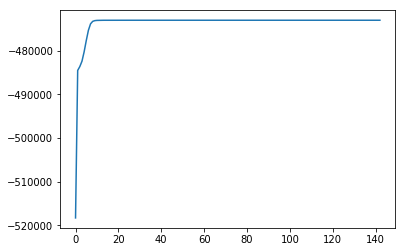

In [154]:
model = MarkovMixture(3)
model.fit(sequences, )

In [147]:
z = model.predict(sequences)

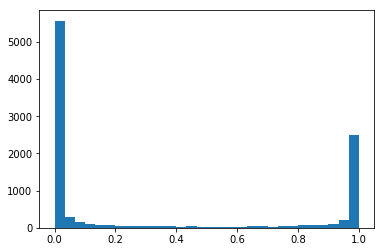

In [152]:
import matplotlib.pyplot as plt

plt.hist(z[:, 0], bins=30)
plt.show()